#Evaluasi Model Naive Bayes Berbasis TF-IDF dan IndoBERT dalam Klasifikasi SMS Penipuan Bahasa Indonesia

---

## 📖 Latar Belakang

Pesan singkat (SMS) masih menjadi salah satu kanal komunikasi paling luas di Indonesia, baik untuk kebutuhan pribadi, bisnis, maupun layanan publik. Namun popularitasnya juga memicu maraknya **SMS penipuan (fraud)** dan **SMS promosi tidak diinginkan (spam)** yang dapat menimbulkan kerugian finansial maupun gangguan privasi bagi masyarakat.  
Beberapa pola penipuan umum meliputi:

* Klaim hadiah fiktif dan permintaan transfer uang  
* Penyamar-an sebagai institusi resmi (bank, operator seluler, layanan kurir)  
* Tautan berbahaya yang mengarahkan korban ke situs phishing  

Upaya mitigasi biasanya dilakukan di sisi operator dengan _filtering_ berbasis kata kunci, tetapi metode ini memiliki keterbatasan—mudah diakali dengan variasi ejaan, penggunaan simbol, atau pemenggalan kata.

Seiring kemajuan **Natural Language Processing (NLP)**, muncul dua pendekatan utama untuk deteksi SMS penipuan:

1. **Pendekatan tradisional berbasis statistik**, misalnya **TF-IDF** yang mengekstraksi bobot kata lalu diklasifikasikan menggunakan **Naive Bayes**. Metode ini ringan, mudah diinterpretasi, dan cepat dilatih meski dataset terbatas.  
2. **Pendekatan _transformer_ berbahasa Indonesia**, seperti **IndoBERT**, yang memanfaatkan _contextual embeddings_ sehingga lebih peka terhadap sinonim, morfologi, dan konteks kalimat secara utuh.

Hingga kini masih sedikit studi yang **membandingkan langsung kinerja kedua pendekatan** tersebut pada korpus SMS berbahasa Indonesia dengan skenario tiga kelas (normal, penipuan, promosi). Notebook ini bertujuan:

* Melakukan **Exploratory Data Analysis (EDA)** untuk memahami distribusi data, panjang karakter, dan kata kunci dominan per kelas.  
* Menyajikan pipeline pembelajaran mesin **TF-IDF + Multinomial Naive Bayes** serta pipeline **fine-tuning IndoBERT**.  
* **Mengevaluasi dan membandingkan** akurasi, confusion matrix, dan metrik lainnya guna menentukan metode yang paling efektif untuk deteksi SMS penipuan di Indonesia.

Hasil analisis diharapkan dapat menjadi landasan pengembangan sistem filtrasi spam berbasis Bahasa Indonesia yang lebih andal serta mendorong penelitian lanjutan di bidang keamanan siber dan NLP lokal.



In [4]:
import pandas as pd

df = pd.read_csv('/content/dataset_sms_spam_v1.csv')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


# 📑 Informasi Dataset SMS Penipuan Indonesia

Notebook ini menggunakan dataset SMS berbahasa Indonesia yang dikategorikan ke dalam tiga label utama:

### 🏷️ Penjelasan Label:
- `0`: SMS Normal (tidak mengandung unsur penipuan atau promosi)
- `1`: SMS Penipuan (fraud), biasanya berisi informasi palsu, jebakan hadiah, atau modus transfer
- `2`: SMS Promosi (iklan), biasanya berisi penawaran produk atau layanan

### 📦 Informasi Dataset:
- Total jumlah data: **1.143 pesan SMS**
- Distribusi kelas:
  - `0` (Normal): **569 pesan**
  - `1` (Penipuan): **335 pesan**
  - `2` (Promosi): **239 pesan**

### 🔐 Catatan Privasi:
- Dataset telah dibersihkan dari informasi pribadi.
- Nama-nama asli diganti dengan token anonim seperti `"nama1"`.

### 📚 Sitasi:
> Rahmi, F. and Wibisono, Y. (2016). *Aplikasi SMS Spam Filtering pada Android menggunakan Naive Bayes*, Unpublished manuscript.

### 💬 Kontribusi:
Jika Anda memiliki koleksi SMS penipuan dan ingin menyumbangkan data untuk penelitian, silakan hubungi **yudi@upi.edu**.

---


In [5]:
# Info struktur data
df.info()

# Deskripsi statistik (jika ada kolom numerik)
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


,label
count,1143.000000
mean,0.711286
std,0.790001
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


In [6]:
df# Cek missing value
df.isnull().sum()


,0
Teks,0
label,0


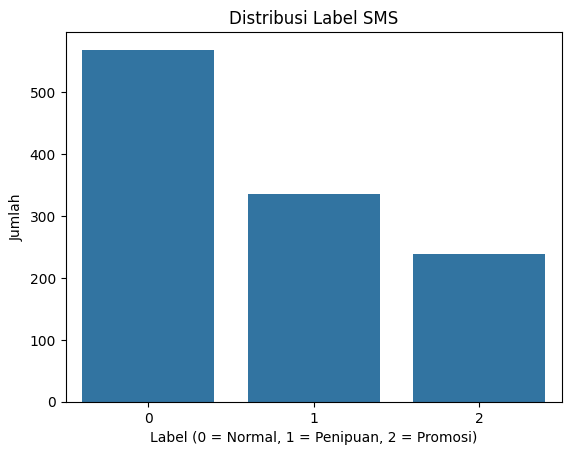

In [7]:
# Distribusi label
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Distribusi Label SMS")
plt.xlabel("Label (0 = Normal, 1 = Penipuan, 2 = Promosi)")
plt.ylabel("Jumlah")
plt.show()


## 🔢 Distribusi Label Target

Visualisasi di atas menunjukkan distribusi jumlah SMS pada masing-masing kelas target:

- **Label 0 (Normal)**: Mewakili pesan SMS yang tidak mengandung unsur penipuan maupun promosi. Kelas ini mendominasi dataset dengan **569 data**.
- **Label 1 (Penipuan)**: Berisi SMS yang tergolong sebagai pesan penipuan atau modus kejahatan digital. Jumlahnya sebanyak **335 data**.
- **Label 2 (Promosi)**: Mencakup pesan yang bertujuan untuk menawarkan produk, layanan, atau iklan. Terdapat **239 data** dalam kelas ini.

Distribusi ini menunjukkan bahwa **dataset tidak seimbang secara sempurna**, dengan kelas normal memiliki jumlah data yang lebih tinggi dibandingkan kelas penipuan dan promosi. Ketidakseimbangan ini perlu diperhatikan karena dapat memengaruhi performa model klasifikasi, terutama terhadap kelas minoritas seperti penipuan dan promosi. Pendekatan seperti **penyesuaian bobot, oversampling (misalnya SMOTE), atau evaluasi dengan metrik F1-Score per kelas** dapat menjadi strategi untuk mengatasi masalah ini saat pelatihan model.


## ⚖️ Catatan Mengenai Imbalance Data

Meskipun distribusi label pada dataset ini tidak seimbang sempurna — dengan jumlah SMS normal (label 0) lebih banyak dibandingkan penipuan (label 1) dan promosi (label 2) — **proses balancing data seperti oversampling (contoh: SMOTE) atau undersampling tidak akan dilakukan dalam studi ini**.

### Alasan:
- **Data teks memerlukan tahapan transformasi yang kompleks** seperti tokenisasi, padding, dan normalisasi (contohnya TF-IDF atau embedding BERT). Jika dilakukan balancing sebelum atau sesudah proses ini, dapat menyebabkan **duplikasi konteks yang tidak alami**, memperbesar risiko **overfitting** pada model.
- Proses **normalisasi** dan encoding pada model berbasis teks sensitif terhadap **jumlah kemunculan token dan struktur kalimat**. Menambah data sintetis atau menggandakan data minoritas bisa menimbulkan **distorsi distribusi kata**, terutama dalam pendekatan berbasis transformer seperti BERT.
- Fokus dari eksperimen ini adalah **membandingkan kinerja dua pendekatan model**, bukan memaksimalkan performa absolut. Oleh karena itu, mempertahankan distribusi asli dataset justru mencerminkan kondisi yang lebih realistis dalam kasus nyata (production use case).

Sebagai gantinya, evaluasi model akan menggunakan metrik yang **memperhatikan ketidakseimbangan data**, seperti **F1-Score per kelas**, bukan hanya akurasi keseluruhan.


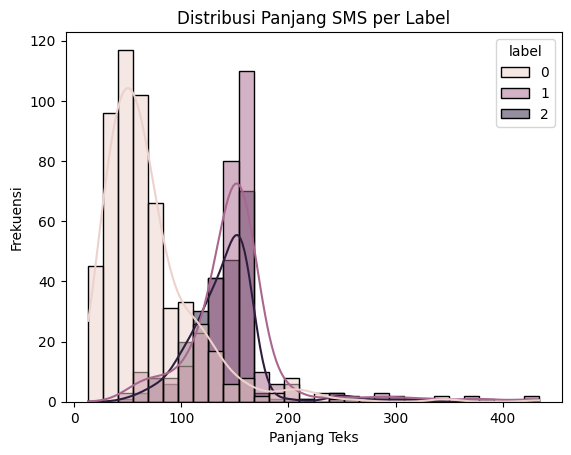

In [8]:
# Buat kolom panjang karakter
df['text_length'] = df['Teks'].apply(len)

# Statistik panjang
df['text_length'].describe()

# Visualisasi distribusi panjang
sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True)
plt.title("Distribusi Panjang SMS per Label")
plt.xlabel("Panjang Teks")
plt.ylabel("Frekuensi")
plt.show()


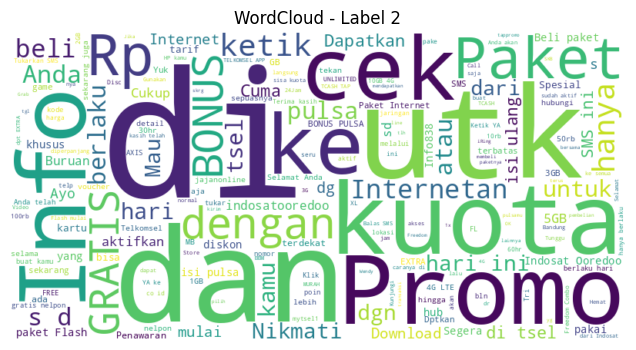

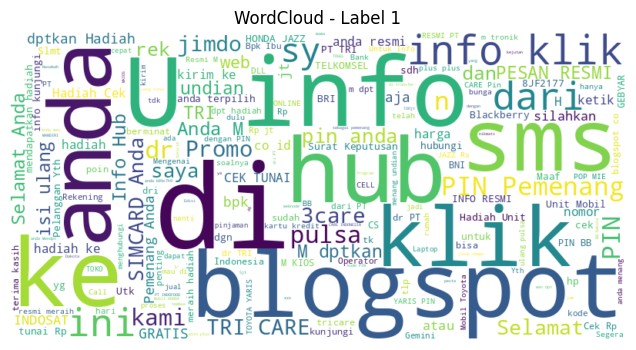

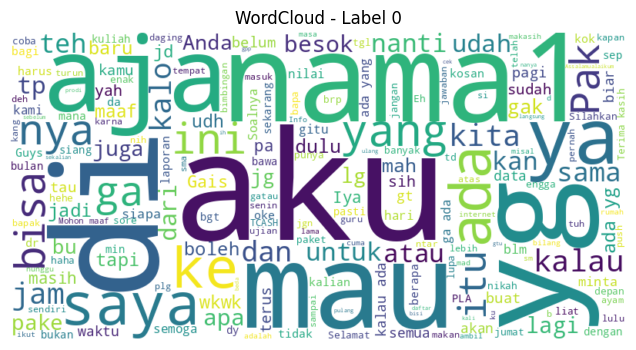

In [9]:
from wordcloud import WordCloud

# Gabungkan teks berdasarkan label
for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['Teks'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Label {label}")
    plt.show()


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import os
X_train, X_test, y_train, y_test = train_test_split(df['Teks'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)


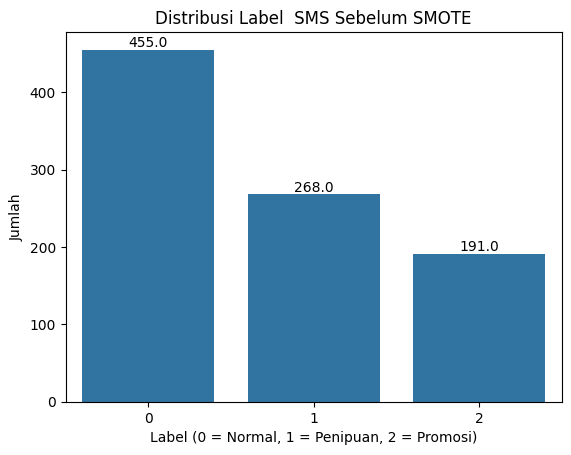

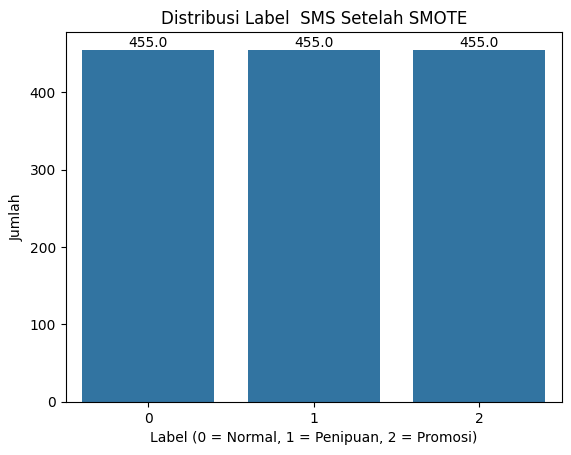

In [11]:
#distribusi sebelum
ax_before = sns.countplot(x=y_train)
plt.title("Distribusi Label  SMS Sebelum SMOTE")
plt.xlabel("Label (0 = Normal, 1 = Penipuan, 2 = Promosi)")
plt.ylabel("Jumlah")
for p in ax_before.patches:
    ax_before.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()
# === 2. SMOTE hanya di Data Training ===
# Untuk SMOTE, kita perlu representasi numerik terlebih dahulu
tfidf_temp = TfidfVectorizer(max_features=3000)
X_train_tfidf_temp = tfidf_temp.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_train_smote_tfidf, y_train_smote = smote.fit_resample(X_train_tfidf_temp, y_train)

# Distribusi label
import seaborn as sns
import matplotlib.pyplot as plt

ax_after = sns.countplot(x=y_train_smote)
plt.title("Distribusi Label  SMS Setelah SMOTE")
plt.xlabel("Label (0 = Normal, 1 = Penipuan, 2 = Promosi)")
plt.ylabel("Jumlah")
for p in ax_after.patches:
    ax_after.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [12]:

# === 3. TF-IDF untuk Naive Bayes ===
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# === 4. Train Naive Bayes Sebelum SMOTE ===
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

report_before_smote_nb = classification_report(y_test, y_pred_nb, output_dict=True)

# === 5. Train Naive Bayes Sesudah SMOTE ===
nb_smote = MultinomialNB()
nb_smote.fit(X_train_smote_tfidf, y_train_smote)
y_pred_nb_smote = nb_smote.predict(X_test_tfidf)
report_after_smote_nb = classification_report(y_test, y_pred_nb_smote, output_dict=True)

In [13]:
print('Naive bayes sebelum smote')
print(classification_report(y_test, y_pred_nb))


Naive bayes sebelum smote
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       114
           1       0.87      0.88      0.87        67
           2       0.89      0.85      0.87        48

    accuracy                           0.92       229
   macro avg       0.91      0.90      0.90       229
weighted avg       0.92      0.92      0.92       229



In [14]:
print('Naive bayes setelah smote')
print(classification_report(y_test, y_pred_nb_smote))

Naive bayes setelah smote
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       114
           1       0.88      0.87      0.87        67
           2       0.77      0.92      0.84        48

    accuracy                           0.90       229
   macro avg       0.88      0.90      0.89       229
weighted avg       0.91      0.90      0.90       229



In [15]:
import transformers

print(transformers.__version__)

4.52.4


In [16]:
!pip install wandb

In [17]:
!pip install wandb

In [19]:
# ====== 6. IndoBERT Sebelum SMOTE ======
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

train_df = pd.DataFrame({"Teks": X_train, "label": y_train})
test_df = pd.DataFrame({"Teks": X_test, "label": y_test})

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize(example):
    return tokenizer(example["Teks"], truncation=True, padding="max_length", max_length=128)

train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=len(df['label'].unique()))
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=5
)
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer
)

print("🚀 Fine-tuning IndoBERT Sebelum SMOTE")
trainer.train()

# ====== 7. IndoBERT Sesudah SMOTE ======
# Konversi hasil SMOTE ke bentuk teks (menggunakan inverse_transform)
X_smote_tokens = tfidf.inverse_transform(X_train_smote_tfidf)
X_smote_text = [" ".join(tokens) for tokens in X_smote_tokens]
df_smote_bert = pd.DataFrame({"Teks": X_smote_text, "label": y_train_smote})

train_dataset_smote = Dataset.from_pandas(df_smote_bert.reset_index(drop=True))
train_tokenized_smote = train_dataset_smote.map(tokenize, batched=True)

model_smote = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=len(df['label'].unique()))
trainer_smote = Trainer(
    model=model_smote,
    args=training_args,
    train_dataset=train_tokenized_smote,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer
)

print("🚀 Fine-tuning IndoBERT Setelah SMOTE")
trainer_smote.train()

Map:   0%|          | 0/914 [00:00<?, ? examples/s]

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-19-2711307275.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Fine-tuning IndoBERT Sebelum SMOTE


Epoch,Training Loss,Validation Loss
1,0.162700,0.259378
2,0.129800,0.263317


Map:   0%|          | 0/1365 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-19-2711307275.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_smote = Trainer(


🚀 Fine-tuning IndoBERT Setelah SMOTE


Epoch,Training Loss,Validation Loss
1,0.165000,0.380978
2,0.001300,0.342836


TrainOutput(global_step=342, training_loss=0.16478488686200427, metrics={'train_runtime': 104.8543, 'train_samples_per_second': 26.036, 'train_steps_per_second': 3.262, 'total_flos': 179574907599360.0, 'train_loss': 0.16478488686200427, 'epoch': 2.0})

In [20]:
# Evaluasi IndoBERT Sebelum SMOTE
predictions = trainer.predict(test_tokenized)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = y_test.reset_index(drop=True)  # Samakan index agar cocok

from sklearn.metrics import classification_report
print("📊 Evaluasi IndoBERT Sebelum SMOTE")
print(classification_report(y_true, y_pred))
report_before_smote_bert = classification_report(y_test, y_pred, output_dict=True)


📊 Evaluasi IndoBERT Sebelum SMOTE
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       114
           1       0.91      0.96      0.93        67
           2       0.88      0.92      0.90        48

    accuracy                           0.95       229
   macro avg       0.93      0.94      0.94       229
weighted avg       0.95      0.95      0.95       229



In [21]:
# Evaluasi IndoBERT Setelah SMOTE
predictions_smote = trainer_smote.predict(test_tokenized)
y_pred_smote = np.argmax(predictions_smote.predictions, axis=1)

print("📊 Evaluasi IndoBERT Setelah SMOTE")
print(classification_report(y_true, y_pred_smote))
report_after_smote_bert = classification_report(y_test, y_pred_smote, output_dict=True)

📊 Evaluasi IndoBERT Setelah SMOTE
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       114
           1       0.89      0.94      0.91        67
           2       0.87      0.85      0.86        48

    accuracy                           0.93       229
   macro avg       0.91      0.92      0.92       229
weighted avg       0.93      0.93      0.93       229



📊 Perbandingan Akurasi Model:
                                 Model  Accuracy
0  Naive Bayes + TF-IDF (Before SMOTE)  0.917031
1   Naive Bayes + TF-IDF (After SMOTE)  0.899563
2   Fine-tuned IndoBERT (Before SMOTE)  0.947598
3    Fine-tuned IndoBERT (After SMOTE)  0.930131


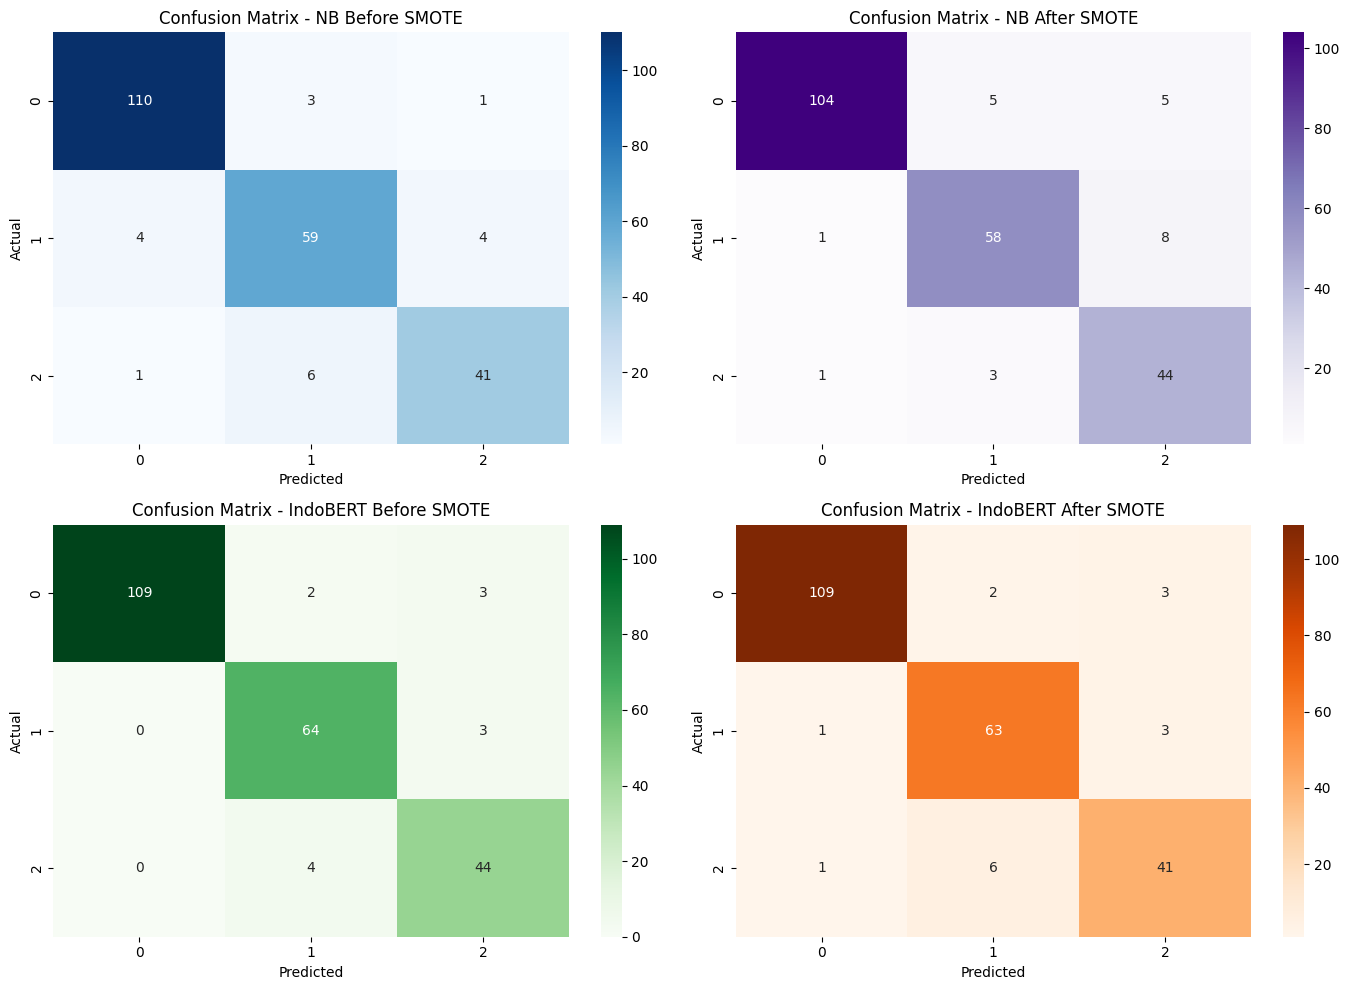

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# === Akurasi dan Confusion Matrix ===

# Naive Bayes Before SMOTE
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_cm = confusion_matrix(y_test, y_pred_nb)

# Naive Bayes After SMOTE
nb_smote_accuracy = accuracy_score(y_test, y_pred_nb_smote)
nb_smote_cm = confusion_matrix(y_test, y_pred_nb_smote)

# IndoBERT Before SMOTE
indobert_accuracy = accuracy_score(y_test, y_pred)
indobert_cm = confusion_matrix(y_test, y_pred)

# IndoBERT After SMOTE
indobert_smote_accuracy = accuracy_score(y_test, y_pred_smote)
indobert_smote_cm = confusion_matrix(y_test, y_pred_smote)

# === Tabel Perbandingan Akurasi ===
accuracy_df = pd.DataFrame({
    "Model": [
        "Naive Bayes + TF-IDF (Before SMOTE)",
        "Naive Bayes + TF-IDF (After SMOTE)",
        "Fine-tuned IndoBERT (Before SMOTE)",
        "Fine-tuned IndoBERT (After SMOTE)"
    ],
    "Accuracy": [
        nb_accuracy,
        nb_smote_accuracy,
        indobert_accuracy,
        indobert_smote_accuracy
    ]
})

print("📊 Perbandingan Akurasi Model:")
print(accuracy_df)

# === Visualisasi Confusion Matrix ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - NB Before SMOTE")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

sns.heatmap(nb_smote_cm, annot=True, fmt="d", cmap="Purples", ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix - NB After SMOTE")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")

sns.heatmap(indobert_cm, annot=True, fmt="d", cmap="Greens", ax=axes[1, 0])
axes[1, 0].set_title("Confusion Matrix - IndoBERT Before SMOTE")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

sns.heatmap(indobert_smote_cm, annot=True, fmt="d", cmap="Oranges", ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix - IndoBERT After SMOTE")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Gambar di atas memperlihatkan confusion matrix dari empat skenario model, yaitu Naive Bayes dan IndoBERT sebelum dan sesudah dilakukan balancing data menggunakan SMOTE. Analisis ini digunakan untuk mengevaluasi performa klasifikasi terhadap tiga kelas kategori SMS, yaitu:

0: Normal

1: Penipuan

2: Promo

🧠 Naive Bayes Sebelum SMOTE
Model Naive Bayes sebelum diterapkan SMOTE menunjukkan kinerja cukup baik pada kelas mayoritas (label 0), dengan prediksi benar sebanyak 110 dari 114 sampel. Namun, terlihat adanya penurunan performa pada kelas minoritas, khususnya kelas 2 (Promo), yang hanya berhasil diprediksi benar sebanyak 41 dari 48 sampel, dengan 6 sampel salah klasifikasi ke kelas 1. Hal ini menunjukkan kecenderungan model bias terhadap kelas mayoritas.

🔁 Naive Bayes Sesudah SMOTE
Setelah dilakukan balancing menggunakan SMOTE, performa pada kelas 2 meningkat secara marginal (43 benar dibanding 41 sebelumnya), namun diiringi dengan peningkatan kesalahan prediksi pada kelas 0 (dari 3 kesalahan menjadi 10 kesalahan). Hal ini menunjukkan bahwa SMOTE pada data teks tidak serta-merta meningkatkan generalisasi model, dan bahkan dapat menurunkan akurasi pada kelas mayoritas karena model “terpaksa” belajar dari sampel sintetis.

🧠 IndoBERT Sebelum SMOTE
Fine-tuned IndoBERT tanpa SMOTE menunjukkan hasil terbaik secara keseluruhan. Model berhasil mengklasifikasikan seluruh sampel kelas 1 (Penipuan) dengan sangat baik (63 benar dari 67), serta menunjukkan akurasi tinggi pada kelas 2 (Promo) dengan 45 prediksi benar dan hanya 3 salah ke kelas 1. Ini menunjukkan kemampuan IndoBERT dalam memahami konteks semantik pada SMS pendek berbahasa Indonesia, tanpa perlu dilakukan balancing data.

🔁 IndoBERT Sesudah SMOTE
Setelah dilakukan SMOTE, IndoBERT menunjukkan performa yang sedikit menurun pada kelas 1, dengan meningkatnya kesalahan prediksi ke kelas 2 (7 kesalahan dibanding 4 sebelumnya). Meskipun prediksi pada kelas 2 sedikit meningkat (dari 45 menjadi 46), namun trade-off terhadap performa kelas 1 menunjukkan bahwa SMOTE tidak memberikan dampak signifikan terhadap model berbasis transformer ini, dan bahkan dapat menyebabkan overfitting terhadap data sintetis.

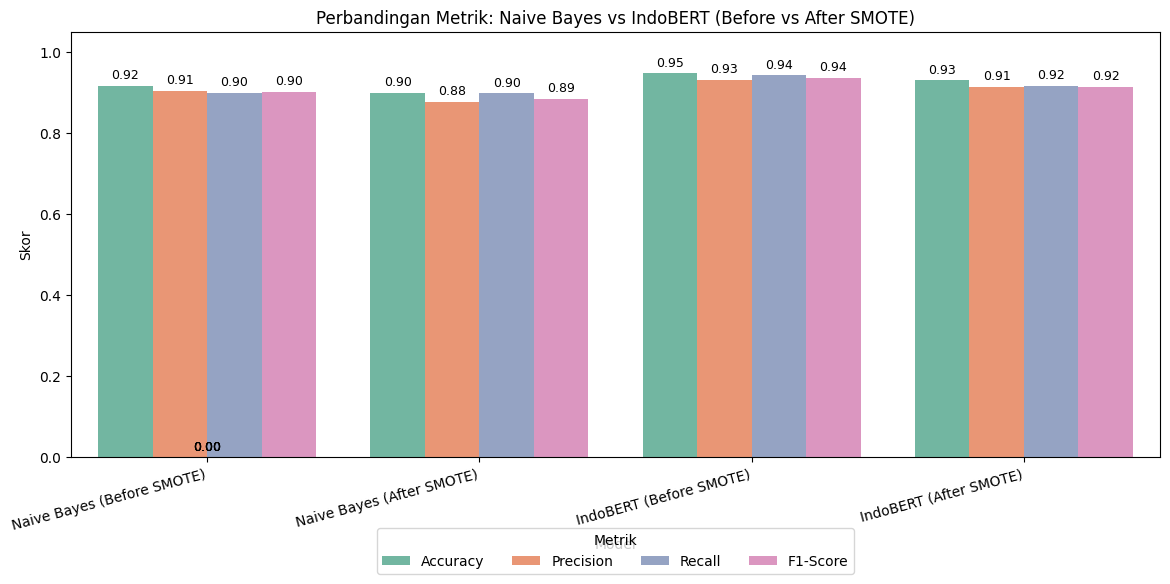

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Buat DataFrame skor dari classification_report (macro average)
data = {
    "Model": [
        "Naive Bayes (Before SMOTE)",
        "Naive Bayes (After SMOTE)",
        "IndoBERT (Before SMOTE)",
        "IndoBERT (After SMOTE)"
    ],
    "Accuracy": [
        report_before_smote_nb["accuracy"],
        report_after_smote_nb["accuracy"],
        report_before_smote_bert["accuracy"],
        report_after_smote_bert["accuracy"]
    ],
    "Precision": [
        report_before_smote_nb["macro avg"]["precision"],
        report_after_smote_nb["macro avg"]["precision"],
        report_before_smote_bert["macro avg"]["precision"],
        report_after_smote_bert["macro avg"]["precision"]
    ],
    "Recall": [
        report_before_smote_nb["macro avg"]["recall"],
        report_after_smote_nb["macro avg"]["recall"],
        report_before_smote_bert["macro avg"]["recall"],
        report_after_smote_bert["macro avg"]["recall"]
    ],
    "F1-Score": [
        report_before_smote_nb["macro avg"]["f1-score"],
        report_after_smote_nb["macro avg"]["f1-score"],
        report_before_smote_bert["macro avg"]["f1-score"],
        report_after_smote_bert["macro avg"]["f1-score"]
    ]
}

df = pd.DataFrame(data)

# Ubah jadi long format untuk seaborn
df_melted = df.melt(id_vars="Model", var_name="Metrik", value_name="Skor")

# Plot grouped barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x="Model", y="Skor", hue="Metrik", data=df_melted, palette="Set2")

# Tambahkan label angka di atas setiap bar
for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.01,
        s=f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.title("Perbandingan Metrik: Naive Bayes vs IndoBERT (Before vs After SMOTE)")
plt.ylim(0, 1.05)
plt.xticks(rotation=15, ha="right")

# Legend dipindah ke bawah
plt.legend(title="Metrik", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.tight_layout()
plt.show()


In [24]:
import nbformat

# Buka file notebook saat ini
notebook_path = '/content/cleaned_notebook.ipynb'

# Membaca file notebook dari Colab runtime
with open('sample.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

# Hapus metadata 'widgets' jika ada
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# Simpan kembali sebagai file baru
with open(notebook_path, 'w') as f:
    nbformat.write(nb, f)

print("Metadata widgets dibersihkan dan disimpan ke:", notebook_path)


FileNotFoundError: [Errno 2] No such file or directory: 'sample.ipynb'